In [115]:
from commonfunctions import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_opening, binary_erosion, binary_closing, thin
from skimage.filters import gaussian as gaussian_filter
import cv2 as cv
import os
from skimage import img_as_ubyte
import functools 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
def char_calculations(A, width, height):
    A_mean = A.mean()
    col_A = 0
    corr_A = 0
    sum_list = np.zeros(shape=(height,width))
    img_row = 0
    while img_row < height:
        img_col = 0
        while img_col < width:
            col_A += (A[img_row, img_col] - A_mean) ** 2
            sum_list[img_row][img_col] = abs(A[img_row, img_col] - A_mean)
            img_col = img_col + 1
        corr_A += col_A
        col_A = 0
        img_row = img_row + 1  
    return corr_A,sum_list

[[58.31444444 58.31444444 58.31444444 ... 65.31444444 68.31444444
  68.31444444]
 [56.31444444 56.31444444 56.31444444 ... 65.31444444 67.31444444
  67.31444444]
 [53.31444444 53.31444444 53.31444444 ... 65.31444444 66.31444444
  66.31444444]
 ...
 [43.31444444 43.31444444 29.31444444 ... 55.31444444 56.31444444
  56.31444444]
 [39.31444444 39.31444444 27.31444444 ... 57.31444444 57.31444444
  57.31444444]
 [35.31444444 35.31444444 24.31444444 ... 58.31444444 58.31444444
  58.31444444]] 11571616.048888892


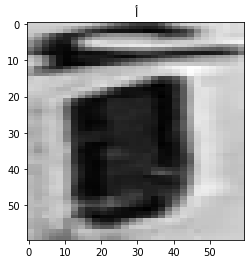

[[48.45 48.45 49.45 ... 35.45 36.45 36.45]
 [50.45 50.45 51.45 ... 35.45 37.45 37.45]
 [51.45 51.45 53.45 ... 35.45 37.45 37.45]
 ...
 [43.45 43.45 47.45 ... 37.45 35.45 35.45]
 [44.45 44.45 47.45 ... 38.45 36.45 36.45]
 [45.45 45.45 47.45 ... 38.45 37.45 37.45]] 11752703.0


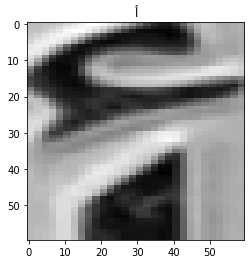

[[136.015 177.015 178.015 ...  37.985  37.985  37.985]
 [169.015 216.015 217.015 ...  37.985  37.985  37.985]
 [170.015 217.015 217.015 ...  37.985  37.985  37.985]
 ...
 [ 37.985  37.985  37.985 ... 217.015 217.015 217.015]
 [ 37.985  37.985  37.985 ... 217.015 217.015 217.015]
 [ 21.985  20.985  20.985 ... 189.015 190.015 189.015]] 27513547.189999923


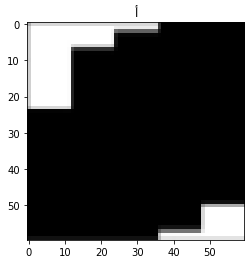

[[77.43 77.43 76.43 ... 75.43 77.43 77.43]
 [77.43 77.43 77.43 ... 76.43 77.43 77.43]
 [76.43 76.43 77.43 ... 77.43 76.43 76.43]
 ...
 [77.43 77.43 77.43 ... 77.43 77.43 77.43]
 [77.43 77.43 77.43 ... 77.43 77.43 77.43]
 [77.43 77.43 77.43 ... 77.43 77.43 77.43]] 43281450.36


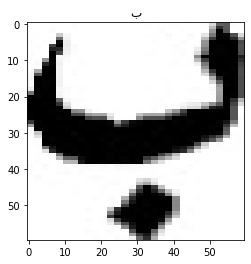

[[113.27833333 113.27833333 113.27833333 ... 113.27833333 112.27833333
  112.27833333]
 [113.27833333 113.27833333 113.27833333 ... 112.27833333 113.27833333
  113.27833333]
 [113.27833333 113.27833333 113.27833333 ... 110.27833333 113.27833333
  113.27833333]
 ...
 [113.27833333 113.27833333 101.27833333 ... 112.27833333 113.27833333
  113.27833333]
 [113.27833333 113.27833333 107.27833333 ... 113.27833333 113.27833333
  113.27833333]
 [113.27833333 113.27833333 113.27833333 ... 113.27833333 113.27833333
  113.27833333]] 51225635.11000004


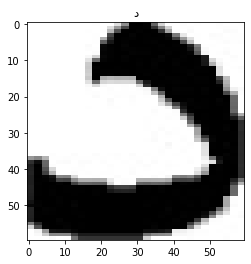

[[38.67777778 38.67777778 39.67777778 ... 49.67777778 46.67777778
  46.67777778]
 [38.67777778 38.67777778 40.67777778 ... 49.67777778 47.67777778
  47.67777778]
 [38.67777778 38.67777778 41.67777778 ... 49.67777778 48.67777778
  48.67777778]
 ...
 [37.67777778 37.67777778 11.67777778 ... 44.67777778 49.67777778
  49.67777778]
 [39.67777778 39.67777778 24.67777778 ... 44.67777778 47.67777778
  47.67777778]
 [40.67777778 40.67777778 36.67777778 ... 44.67777778 45.67777778
  45.67777778]] 11711022.222222226


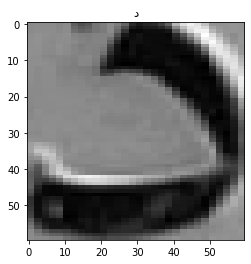

[[65.47888889 65.47888889 65.47888889 ... 63.47888889 65.47888889
  65.47888889]
 [65.47888889 65.47888889 65.47888889 ... 64.47888889 64.47888889
  64.47888889]
 [65.47888889 65.47888889 65.47888889 ... 65.47888889 62.47888889
  62.47888889]
 ...
 [63.47888889 63.47888889 64.47888889 ... 63.47888889 65.47888889
  65.47888889]
 [64.47888889 64.47888889 65.47888889 ... 64.47888889 65.47888889
  65.47888889]
 [64.47888889 64.47888889 65.47888889 ... 65.47888889 65.47888889
  65.47888889]] 39303342.395555556


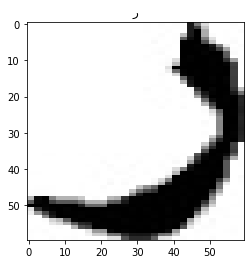

[[36.48277778 36.48277778 38.48277778 ... 68.48277778 44.48277778
  44.48277778]
 [37.48277778 37.48277778 38.48277778 ... 63.48277778 46.48277778
  46.48277778]
 [37.48277778 37.48277778 37.48277778 ... 58.48277778 48.48277778
  48.48277778]
 ...
 [33.48277778 33.48277778 33.48277778 ... 33.48277778 33.48277778
  33.48277778]
 [34.48277778 34.48277778 34.48277778 ... 33.48277778 33.48277778
  33.48277778]
 [34.48277778 34.48277778 34.48277778 ... 33.48277778 33.48277778
  33.48277778]] 11229506.932222217


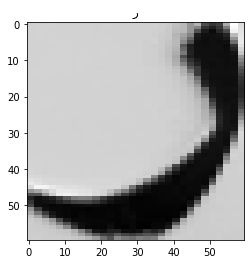

[[59.675 59.675 59.675 ... 59.675 59.675 27.675]
 [59.675 59.675 59.675 ... 59.675 59.675 27.675]
 [59.675 59.675 59.675 ... 59.675 59.675 27.675]
 ...
 [59.675 58.675 59.675 ... 59.675 59.675 27.675]
 [59.675 59.675 59.675 ... 59.675 58.675 26.675]
 [14.325  2.325  2.325 ...  2.325  2.325 18.325]] 37948667.74999998


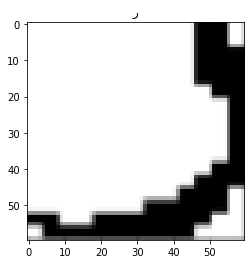

[[14.37638889 26.62361111 26.62361111 ... 26.62361111 26.62361111
  26.62361111]
 [18.62361111 65.62361111 66.62361111 ... 66.62361111 66.62361111
  66.62361111]
 [19.62361111 66.62361111 66.62361111 ... 61.62361111 61.62361111
  61.62361111]
 ...
 [14.62361111 61.62361111 61.62361111 ... 66.62361111 66.62361111
  66.62361111]
 [18.62361111 65.62361111 65.62361111 ... 66.62361111 66.62361111
  66.62361111]
 [18.62361111 62.62361111 63.62361111 ... 63.62361111 63.62361111
  63.62361111]] 40973888.99305555


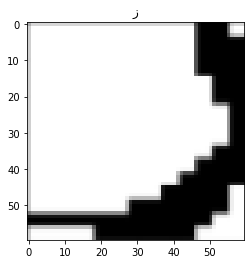

[[ 61.29388889  61.29388889  60.29388889 ...  54.70611111  21.70611111
   21.70611111]
 [ 60.29388889  60.29388889  60.29388889 ...  78.70611111  37.70611111
   37.70611111]
 [ 58.29388889  58.29388889  59.29388889 ... 103.70611111  53.70611111
   53.70611111]
 ...
 [ 59.29388889  59.29388889  44.29388889 ...  59.29388889  59.29388889
   59.29388889]
 [ 61.29388889  61.29388889  50.29388889 ...  60.29388889  60.29388889
   60.29388889]
 [ 62.29388889  62.29388889  56.29388889 ...  60.29388889  61.29388889
   61.29388889]] 19401931.06555556


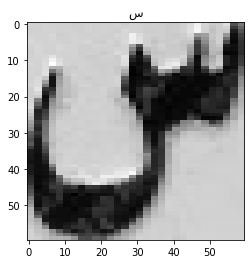

[[98.42055556 98.42055556 99.42055556 ... 99.42055556 99.42055556
  99.42055556]
 [99.42055556 99.42055556 99.42055556 ... 99.42055556 99.42055556
  99.42055556]
 [99.42055556 99.42055556 98.42055556 ... 99.42055556 99.42055556
  99.42055556]
 ...
 [94.42055556 94.42055556 99.42055556 ... 99.42055556 99.42055556
  99.42055556]
 [97.42055556 97.42055556 99.42055556 ... 98.42055556 99.42055556
  99.42055556]
 [99.42055556 99.42055556 99.42055556 ... 96.42055556 99.42055556
  99.42055556]] 48152125.27888889


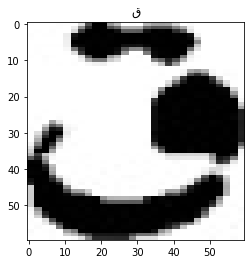

[[ 9.8775 58.8775 59.8775 ... 59.8775 58.8775 25.8775]
 [40.8775 97.8775 98.8775 ... 98.8775 97.8775 53.8775]
 [41.8775 98.8775 98.8775 ... 97.8775 98.8775 53.8775]
 ...
 [41.8775 98.8775 98.8775 ... 98.8775 98.8775 53.8775]
 [40.8775 97.8775 98.8775 ... 98.8775 98.8775 53.8775]
 [21.8775 70.8775 70.8775 ... 70.8775 70.8775 36.8775]] 50320258.560000025


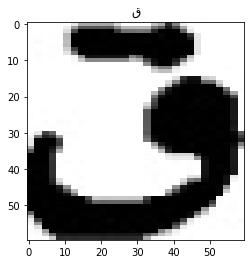

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 50493538.97749997


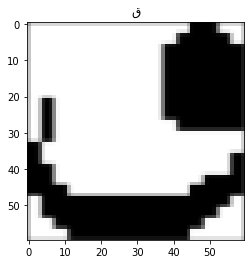

[[84.10166667 84.10166667 85.10166667 ... 84.10166667 85.10166667
  85.10166667]
 [85.10166667 85.10166667 83.10166667 ... 83.10166667 85.10166667
  85.10166667]
 [85.10166667 85.10166667 81.10166667 ... 81.10166667 85.10166667
  85.10166667]
 ...
 [85.10166667 85.10166667 85.10166667 ... 85.10166667 85.10166667
  85.10166667]
 [85.10166667 85.10166667 84.10166667 ... 85.10166667 85.10166667
  85.10166667]
 [85.10166667 85.10166667 83.10166667 ... 85.10166667 85.10166667
  85.10166667]] 46368096.78999996


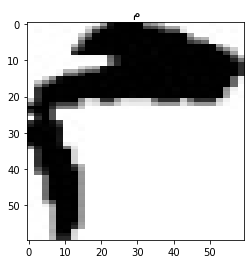

[[87.27111111 87.27111111 87.27111111 ... 87.27111111 87.27111111
  87.27111111]
 [87.27111111 87.27111111 87.27111111 ... 87.27111111 87.27111111
  87.27111111]
 [87.27111111 87.27111111 87.27111111 ... 87.27111111 87.27111111
  87.27111111]
 ...
 [86.27111111 86.27111111 85.27111111 ... 87.27111111 87.27111111
  87.27111111]
 [87.27111111 87.27111111 86.27111111 ... 87.27111111 87.27111111
  87.27111111]
 [87.27111111 87.27111111 87.27111111 ... 86.27111111 87.27111111
  87.27111111]] 47448787.395555556


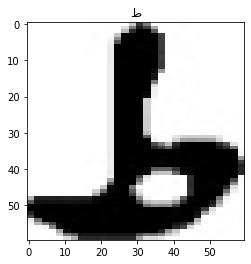

[[ 90.16611111  90.16611111  90.16611111 ...  63.16611111  89.16611111
   89.16611111]
 [ 90.16611111  90.16611111  90.16611111 ...  27.83388889  83.16611111
   83.16611111]
 [ 90.16611111  90.16611111  90.16611111 ... 118.83388889  76.16611111
   76.16611111]
 ...
 [ 90.16611111  90.16611111  90.16611111 ...  90.16611111  90.16611111
   90.16611111]
 [ 89.16611111  89.16611111  90.16611111 ...  90.16611111  90.16611111
   90.16611111]
 [ 87.16611111  87.16611111  90.16611111 ...  90.16611111  90.16611111
   90.16611111]] 46483626.66555556


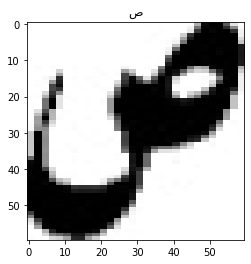

[[82.42166667 82.42166667 82.42166667 ... 81.42166667 82.42166667
  82.42166667]
 [82.42166667 82.42166667 82.42166667 ... 82.42166667 82.42166667
  82.42166667]
 [82.42166667 82.42166667 82.42166667 ... 82.42166667 81.42166667
  81.42166667]
 ...
 [82.42166667 82.42166667 81.42166667 ... 81.42166667 81.42166667
  81.42166667]
 [82.42166667 82.42166667 82.42166667 ... 82.42166667 82.42166667
  82.42166667]
 [82.42166667 82.42166667 82.42166667 ... 82.42166667 82.42166667
  82.42166667]] 45218897.91


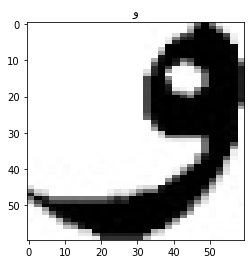

[[53.305 53.305 53.305 ... 51.305 52.305 52.305]
 [53.305 53.305 53.305 ... 51.305 50.305 50.305]
 [53.305 53.305 53.305 ... 50.305 48.305 48.305]
 ...
 [37.305 37.305 38.305 ... 39.305 37.305 37.305]
 [39.305 39.305 37.305 ... 38.305 37.305 37.305]
 [40.305 40.305 35.305 ... 37.305 36.305 36.305]] 12423875.11


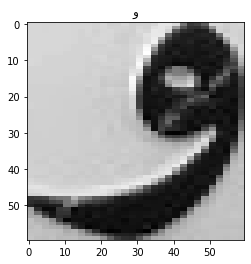

[[121.39166667 121.39166667 119.39166667 ... 122.39166667 116.39166667
  116.39166667]
 [119.39166667 119.39166667 121.39166667 ... 120.39166667 119.39166667
  119.39166667]
 [116.39166667 116.39166667 122.39166667 ... 117.39166667 122.39166667
  122.39166667]
 ...
 [121.39166667 121.39166667 119.39166667 ... 122.39166667 122.39166667
  122.39166667]
 [122.39166667 122.39166667 120.39166667 ... 122.39166667 122.39166667
  122.39166667]
 [122.39166667 122.39166667 121.39166667 ... 121.39166667 122.39166667
  122.39166667]] 49502945.74999999


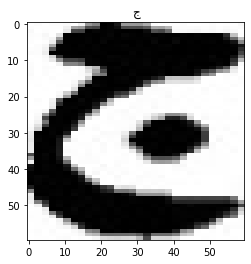

[[23.16055556 23.16055556 22.16055556 ... 11.16055556 21.16055556
  21.16055556]
 [24.16055556 24.16055556 23.16055556 ...  4.16055556 14.16055556
  14.16055556]
 [24.16055556 24.16055556 23.16055556 ...  2.83944444  6.16055556
   6.16055556]
 ...
 [30.16055556 30.16055556 29.16055556 ... 34.16055556 28.16055556
  28.16055556]
 [30.16055556 30.16055556 30.16055556 ... 32.16055556 31.16055556
  31.16055556]
 [30.16055556 30.16055556 31.16055556 ... 29.16055556 33.16055556
  33.16055556]] 7528057.19888889


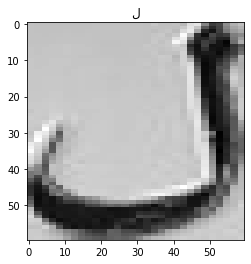

[[64.98166667 64.98166667 63.98166667 ... 39.98166667 59.98166667
  59.98166667]
 [64.98166667 64.98166667 64.98166667 ... 10.01833333 52.98166667
  52.98166667]
 [64.98166667 64.98166667 64.98166667 ... 60.01833333 44.98166667
  44.98166667]
 ...
 [68.98166667 68.98166667 67.98166667 ... 64.98166667 61.98166667
  61.98166667]
 [67.98166667 67.98166667 67.98166667 ... 62.98166667 61.98166667
  61.98166667]
 [66.98166667 66.98166667 66.98166667 ... 60.98166667 61.98166667
  61.98166667]] 19869768.79


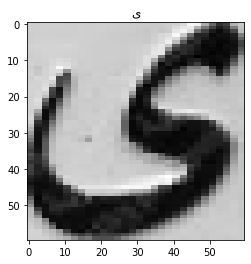

[[51.37166667 51.37166667 52.37166667 ... 54.37166667 53.37166667
  53.37166667]
 [53.37166667 53.37166667 54.37166667 ... 55.37166667 54.37166667
  54.37166667]
 [54.37166667 54.37166667 55.37166667 ... 55.37166667 54.37166667
  54.37166667]
 ...
 [46.37166667 46.37166667 47.37166667 ... 45.37166667 45.37166667
  45.37166667]
 [45.37166667 45.37166667 46.37166667 ... 45.37166667 45.37166667
  45.37166667]
 [44.37166667 44.37166667 45.37166667 ... 45.37166667 44.37166667
  44.37166667]] 13922528.709999999


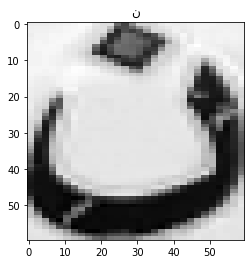

[[55.12888889 55.12888889 54.12888889 ... 51.12888889 51.12888889
  51.12888889]
 [55.12888889 55.12888889 54.12888889 ... 51.12888889 51.12888889
  51.12888889]
 [54.12888889 54.12888889 53.12888889 ... 51.12888889 51.12888889
  51.12888889]
 ...
 [41.12888889 41.12888889 45.12888889 ... 40.12888889 41.12888889
  41.12888889]
 [41.12888889 41.12888889 44.12888889 ... 40.12888889 41.12888889
  41.12888889]
 [40.12888889 40.12888889 42.12888889 ... 40.12888889 40.12888889
  40.12888889]] 14090992.195555555


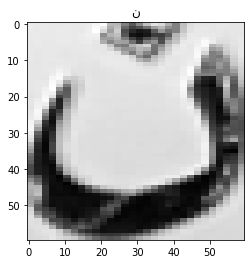

[[ 0.90666667 38.09333333 38.09333333 ... 38.09333333 38.09333333
  20.09333333]
 [37.09333333 90.09333333 90.09333333 ... 85.09333333 89.09333333
  66.09333333]
 [37.09333333 90.09333333 90.09333333 ...  0.90666667 73.09333333
  66.09333333]
 ...
 [37.09333333 90.09333333 90.09333333 ... 90.09333333 90.09333333
  66.09333333]
 [37.09333333 90.09333333 90.09333333 ... 90.09333333 90.09333333
  66.09333333]
 [ 7.09333333 49.09333333 49.09333333 ... 49.09333333 49.09333333
  29.09333333]] 49494560.64000003


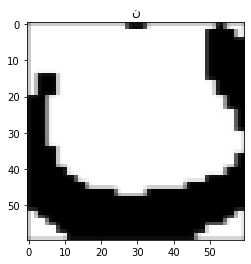

[[49.00222222 49.00222222 49.00222222 ... 45.00222222 47.00222222
  47.00222222]
 [49.00222222 49.00222222 50.00222222 ... 43.00222222 46.00222222
  46.00222222]
 [49.00222222 49.00222222 50.00222222 ... 40.00222222 44.00222222
  44.00222222]
 ...
 [51.00222222 51.00222222 51.00222222 ... 50.00222222 52.00222222
  52.00222222]
 [51.00222222 51.00222222 51.00222222 ... 50.00222222 52.00222222
  52.00222222]
 [50.00222222 50.00222222 50.00222222 ... 50.00222222 51.00222222
  51.00222222]] 17223691.982222218


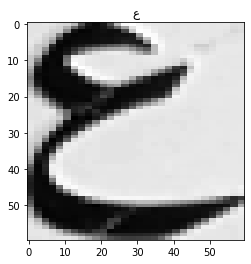

[[69.20555556 69.20555556 69.20555556 ... 68.20555556 68.20555556
  68.20555556]
 [69.20555556 69.20555556 69.20555556 ... 69.20555556 69.20555556
  69.20555556]
 [68.20555556 68.20555556 68.20555556 ... 69.20555556 70.20555556
  70.20555556]
 ...
 [66.20555556 66.20555556 67.20555556 ... 63.20555556 69.20555556
  69.20555556]
 [68.20555556 68.20555556 67.20555556 ... 64.20555556 67.20555556
  67.20555556]
 [70.20555556 70.20555556 66.20555556 ... 64.20555556 64.20555556
  64.20555556]] 20846735.888888903


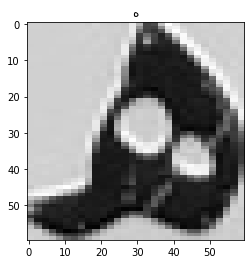

[[46.39555556 46.39555556 43.39555556 ... 52.39555556 51.39555556
  51.39555556]
 [48.39555556 48.39555556 45.39555556 ... 52.39555556 51.39555556
  51.39555556]
 [49.39555556 49.39555556 47.39555556 ... 52.39555556 51.39555556
  51.39555556]
 ...
 [46.39555556 46.39555556 51.39555556 ... 55.39555556 56.39555556
  56.39555556]
 [49.39555556 49.39555556 49.39555556 ... 57.39555556 58.39555556
  58.39555556]
 [51.39555556 51.39555556 46.39555556 ... 59.39555556 59.39555556
  59.39555556]] 12982324.72888889


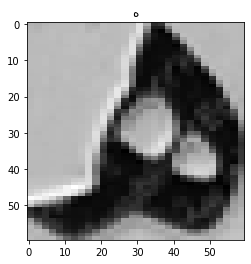

[[66.79555556 66.79555556 67.79555556 ... 67.79555556 68.79555556
  68.79555556]
 [67.79555556 67.79555556 67.79555556 ... 68.79555556 68.79555556
  68.79555556]
 [68.79555556 68.79555556 67.79555556 ... 68.79555556 67.79555556
  67.79555556]
 ...
 [60.79555556 60.79555556 45.79555556 ... 62.79555556 63.79555556
  63.79555556]
 [63.79555556 63.79555556 53.79555556 ... 62.79555556 62.79555556
  62.79555556]
 [65.79555556 65.79555556 61.79555556 ... 61.79555556 61.79555556
  61.79555556]] 16135325.528888889


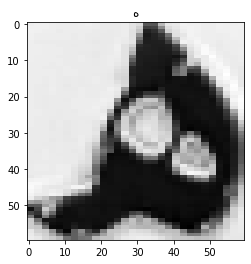

[[45.34722222 45.34722222 46.34722222 ... 48.34722222 46.34722222
  46.34722222]
 [45.34722222 45.34722222 46.34722222 ... 46.34722222 46.34722222
  46.34722222]
 [45.34722222 45.34722222 46.34722222 ... 44.34722222 45.34722222
  45.34722222]
 ...
 [ 3.34722222  3.34722222 57.65277778 ... 45.34722222 44.34722222
  44.34722222]
 [17.34722222 17.34722222 23.65277778 ... 45.34722222 44.34722222
  44.34722222]
 [30.34722222 30.34722222  9.34722222 ... 44.34722222 44.34722222
  44.34722222]] 10107515.97222222


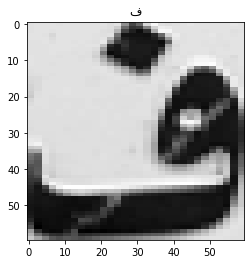

[[58.01777778 58.01777778 58.01777778 ... 61.01777778 60.01777778
  60.01777778]
 [57.01777778 57.01777778 57.01777778 ... 61.01777778 60.01777778
  60.01777778]
 [55.01777778 55.01777778 56.01777778 ... 60.01777778 59.01777778
  59.01777778]
 ...
 [40.01777778 40.01777778 12.01777778 ... 55.01777778 52.01777778
  52.01777778]
 [40.01777778 40.01777778 24.01777778 ... 54.01777778 57.01777778
  57.01777778]
 [40.01777778 40.01777778 36.01777778 ... 53.01777778 62.01777778
  62.01777778]] 17081778.86222222


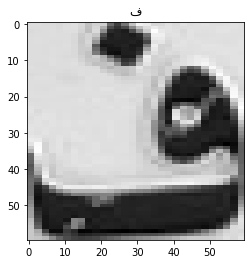

[[ 24.02944444  77.02944444  78.02944444 ...  78.02944444  78.02944444
   65.02944444]
 [ 62.02944444 125.02944444 125.02944444 ... 125.02944444 125.02944444
  107.02944444]
 [ 62.02944444 125.02944444 125.02944444 ... 124.02944444 125.02944444
  107.02944444]
 ...
 [ 63.02944444 125.02944444 124.02944444 ... 100.02944444 125.02944444
  107.02944444]
 [ 62.02944444 125.02944444 125.02944444 ... 100.02944444 125.02944444
  107.02944444]
 [ 35.02944444  69.02944444  70.02944444 ...  53.02944444  70.02944444
   59.02944444]] 53731120.87888893


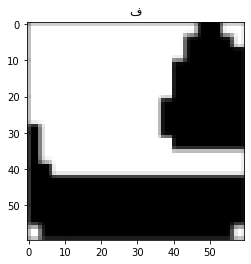

[[64.98166667 64.98166667 63.98166667 ... 39.98166667 59.98166667
  59.98166667]
 [64.98166667 64.98166667 64.98166667 ... 10.01833333 52.98166667
  52.98166667]
 [64.98166667 64.98166667 64.98166667 ... 60.01833333 44.98166667
  44.98166667]
 ...
 [68.98166667 68.98166667 67.98166667 ... 64.98166667 61.98166667
  61.98166667]
 [67.98166667 67.98166667 67.98166667 ... 62.98166667 61.98166667
  61.98166667]
 [66.98166667 66.98166667 66.98166667 ... 60.98166667 61.98166667
  61.98166667]] 19869768.79


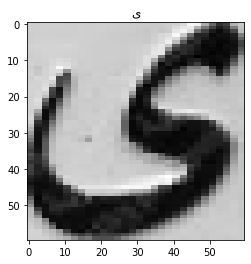

[[130.64277778 130.64277778 131.64277778 ... 131.64277778 131.64277778
  131.64277778]
 [131.64277778 131.64277778 129.64277778 ... 131.64277778 131.64277778
  131.64277778]
 [131.64277778 131.64277778 126.64277778 ... 131.64277778 131.64277778
  131.64277778]
 ...
 [131.64277778 131.64277778 131.64277778 ... 127.64277778 131.64277778
  131.64277778]
 [131.64277778 131.64277778 131.64277778 ... 129.64277778 131.64277778
  131.64277778]
 [131.64277778 131.64277778 131.64277778 ... 131.64277778 131.64277778
  131.64277778]] 53703478.61222222


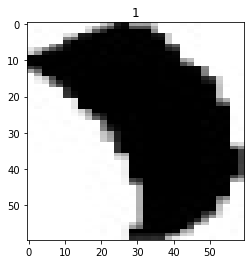

[[106.96388889 106.96388889 104.96388889 ... 106.96388889 104.96388889
  104.96388889]
 [105.96388889 105.96388889 105.96388889 ...  75.96388889  76.96388889
   76.96388889]
 [104.96388889 104.96388889 106.96388889 ...  43.96388889  47.96388889
   47.96388889]
 ...
 [106.96388889 106.96388889 106.96388889 ... 106.96388889 106.96388889
  106.96388889]
 [106.96388889 106.96388889 106.96388889 ... 106.96388889 106.96388889
  106.96388889]
 [106.96388889 106.96388889 106.96388889 ... 106.96388889 106.96388889
  106.96388889]] 50887901.30555552


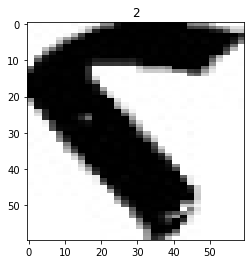

[[122.22638889 122.22638889 122.22638889 ... 122.22638889 122.22638889
  122.22638889]
 [122.22638889 122.22638889 122.22638889 ... 122.22638889 122.22638889
  122.22638889]
 [122.22638889 122.22638889 122.22638889 ... 122.22638889 122.22638889
  122.22638889]
 ...
 [ 74.77361111 132.77361111 132.77361111 ... 132.77361111 132.77361111
  132.77361111]
 [ 74.77361111 131.77361111 132.77361111 ... 132.77361111 132.77361111
  132.77361111]
 [ 55.77361111 104.77361111 104.77361111 ... 104.77361111 105.77361111
  104.77361111]] 55180144.493055575


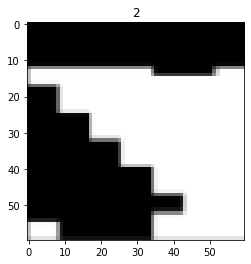

[[ 92.93611111  92.93611111  90.93611111 ...  64.93611111  12.06388889
   12.06388889]
 [ 92.93611111  92.93611111  91.93611111 ...  35.06388889  67.06388889
   67.06388889]
 [ 92.93611111  92.93611111  92.93611111 ... 135.06388889 122.06388889
  122.06388889]
 ...
 [ 92.93611111  92.93611111  92.93611111 ...  92.93611111  92.93611111
   92.93611111]
 [ 92.93611111  92.93611111  92.93611111 ...  92.93611111  92.93611111
   92.93611111]
 [ 92.93611111  92.93611111  92.93611111 ...  92.93611111  92.93611111
   92.93611111]] 48665583.305555575


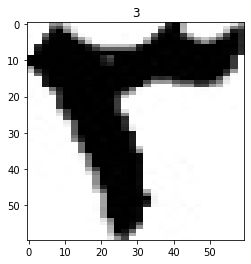

[[101.295 101.295  99.295 ... 101.295 101.295 101.295]
 [101.295 101.295  99.295 ... 101.295 101.295 101.295]
 [101.295 101.295  98.295 ... 101.295 101.295 101.295]
 ...
 [101.295 101.295  99.295 ... 101.295 100.295 100.295]
 [101.295 101.295 100.295 ... 101.295  99.295  99.295]
 [101.295 101.295 100.295 ... 101.295  97.295  97.295]] 48821576.70999999


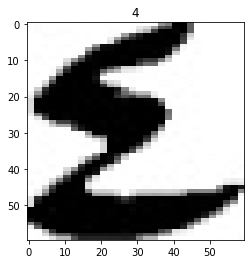

[[141.70722222 141.70722222 141.70722222 ... 141.70722222 141.70722222
  141.70722222]
 [141.70722222 141.70722222 141.70722222 ... 140.70722222 140.70722222
  140.70722222]
 [141.70722222 141.70722222 141.70722222 ... 138.70722222 139.70722222
  139.70722222]
 ...
 [139.70722222 139.70722222 141.70722222 ... 140.70722222 139.70722222
  139.70722222]
 [140.70722222 140.70722222 141.70722222 ... 140.70722222 140.70722222
  140.70722222]
 [141.70722222 141.70722222 141.70722222 ... 140.70722222 141.70722222
  141.70722222]] 50728241.412222244


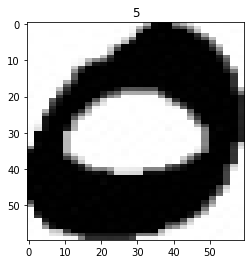

[[ 85.87111111  85.87111111  38.12888889 ...  98.87111111  98.87111111
   98.87111111]
 [ 76.87111111  76.87111111  97.12888889 ...  98.87111111  98.87111111
   98.87111111]
 [ 66.87111111  66.87111111 156.12888889 ...  98.87111111  97.87111111
   97.87111111]
 ...
 [ 98.87111111  98.87111111  98.87111111 ...  94.87111111  96.87111111
   96.87111111]
 [ 98.87111111  98.87111111  98.87111111 ...  96.87111111  97.87111111
   97.87111111]
 [ 98.87111111  98.87111111  98.87111111 ...  98.87111111  98.87111111
   98.87111111]] 50875892.19555552


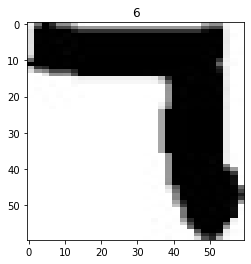

[[26.39111111 26.39111111 69.60888889 ... 58.39111111 57.39111111
  57.39111111]
 [ 4.39111111  4.39111111 70.60888889 ... 40.39111111 49.39111111
  49.39111111]
 [17.60888889 17.60888889 72.60888889 ... 22.39111111 40.39111111
  40.39111111]
 ...
 [51.39111111 51.39111111 50.39111111 ... 51.39111111 49.39111111
  49.39111111]
 [52.39111111 52.39111111 50.39111111 ... 52.39111111 50.39111111
  50.39111111]
 [53.39111111 53.39111111 50.39111111 ... 52.39111111 51.39111111
  51.39111111]] 17031645.315555558


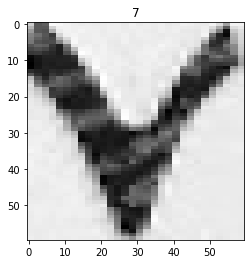

[[ 89.14333333  89.14333333  89.14333333 ...  89.14333333  89.14333333
   89.14333333]
 [ 89.14333333  89.14333333  89.14333333 ...  89.14333333  89.14333333
   89.14333333]
 [ 89.14333333  89.14333333  89.14333333 ...  89.14333333  89.14333333
   89.14333333]
 ...
 [163.85666667 163.85666667 165.85666667 ...  89.14333333  87.14333333
   87.14333333]
 [ 53.85666667  53.85666667  55.85666667 ...  88.14333333  88.14333333
   88.14333333]
 [ 55.14333333  55.14333333  54.14333333 ...  86.14333333  89.14333333
   89.14333333]] 47325350.03999999


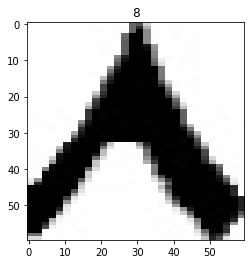

[[95.17555556 95.17555556 95.17555556 ... 95.17555556 95.17555556
  95.17555556]
 [95.17555556 95.17555556 95.17555556 ... 95.17555556 95.17555556
  95.17555556]
 [94.17555556 94.17555556 94.17555556 ... 95.17555556 95.17555556
  95.17555556]
 ...
 [95.17555556 95.17555556 95.17555556 ... 95.17555556 95.17555556
  95.17555556]
 [95.17555556 95.17555556 95.17555556 ... 95.17555556 95.17555556
  95.17555556]
 [95.17555556 95.17555556 95.17555556 ... 95.17555556 94.17555556
  94.17555556]] 49034097.04888886


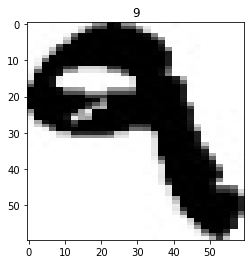

In [152]:
width = 60
height = 60

class character:
    def __init__(self, char, template):
        self.char = char
        self.template = cv.resize(cv.imread(template,cv.IMREAD_GRAYSCALE), (60, 60), interpolation = cv.INTER_AREA)
        self.col_sum = np.zeros(shape=(height,width))
        self.corr = 0
        
database_characters = []

# Letters
Alf = character("أ", 'charImages/alf3.jpg')
Alf2 = character("أ", 'charImages/alf5.png')
Alf3 = character("أ", 'charImages/alf6.jpg')
Sen = character("س", 'charImages/sen.jpg')
Non = character("ن", 'charImages/non2.png')
Non2 = character("ن", 'charImages/non5.png')
Non3 = character("ن", 'charImages/non3.jpg')
Yeh = character("ى", 'charImages/yeh.jpg')
Lam = character("ل", 'charImages/lam3.jpg')
Bih = character("ب", 'charImages/30.jpg')
Dal = character("د", 'charImages/32.jpg')
Dal2 = character("د", 'charImages/dal4.jpg')
Reh = character("ر", 'charImages/36.jpg')
Reh2 = character("ر", 'charImages/reh5.png')
Reh3 = character("ر", "charImages/ra'.jpg")
Zay = character("ز", "charImages/zay.jpg")
Qaf = character("ق", 'charImages/86.jpg')
Qaf2 = character("ق", 'charImages/88.jpg')
Qaf3 = character("ق", 'charImages/qaf.jpg')
Mim = character("م", 'charImages/33.jpg')
Waw = character("و", 'charImages/7.jpg')
Waw2 = character("و", 'charImages/waw2.jpg')
Tah = character("ط", 'charImages/82.jpg')
Sad = character("ص", 'charImages/42.jpg')
Gem = character("ج", 'charImages/102.jpg')
Ein = character("ع", 'charImages/ein.png')
Heh = character("ه", 'charImages/heh2.jpg')
Heh2 = character("ه", 'charImages/heh3.png')
Heh3 = character("ه", 'charImages/heh4.png')
Fih = character("ف", 'charImages/fih3.png')
Fih2 = character("ف", 'charImages/fih2.jpg')
Fih3 = character("ف", "charImages/fa'.jpg")

Alf.corr, Alf.col_sum = char_calculations(Alf.template, height, width)
Alf2.corr, Alf2.col_sum = char_calculations(Alf2.template, height, width)
Alf3.corr, Alf3.col_sum = char_calculations(Alf3.template, height, width)
Sen.corr, Sen.col_sum = char_calculations(Sen.template, height, width)
Non.corr, Non.col_sum = char_calculations(Non.template, height, width)
Non2.corr, Non2.col_sum = char_calculations(Non2.template, height, width)
Non3.corr, Non3.col_sum = char_calculations(Non3.template, height, width)
Yeh.corr, Yeh.col_sum = char_calculations(Yeh.template, height, width)
Lam.corr, Lam.col_sum = char_calculations(Lam.template, height, width)
Bih.corr, Bih.col_sum = char_calculations(Bih.template, height, width)
Dal.corr, Dal.col_sum = char_calculations(Dal.template, height, width)
Dal2.corr, Dal2.col_sum = char_calculations(Dal2.template, height, width)
Reh.corr, Reh.col_sum = char_calculations(Reh.template, height, width)
Reh2.corr, Reh2.col_sum = char_calculations(Reh2.template, height, width)
Reh3.corr, Reh3.col_sum = char_calculations(Reh3.template, height, width)
Zay.corr, Zay.col_sum = char_calculations(Zay.template, height, width)
Qaf.corr, Qaf.col_sum = char_calculations(Qaf.template, height, width)
Qaf2.corr, Qaf2.col_sum = char_calculations(Qaf2.template, height, width)
Qaf3.corr, Qaf2.col_sum = char_calculations(Qaf3.template, height, width)
Mim.corr, Mim.col_sum = char_calculations(Mim.template, height, width)
Waw.corr, Waw.col_sum = char_calculations(Waw.template, height, width)
Waw2.corr, Waw2.col_sum = char_calculations(Waw2.template, height, width)
Tah.corr, Tah.col_sum = char_calculations(Tah.template, height, width)
Sad.corr, Sad.col_sum = char_calculations(Sad.template, height, width)
Gem.corr, Gem.col_sum = char_calculations(Gem.template, height, width)
Ein.corr, Ein.col_sum = char_calculations(Ein.template, height, width)
Heh.corr, Heh.col_sum = char_calculations(Heh.template, height, width)
Heh2.corr, Heh2.col_sum = char_calculations(Heh2.template, height, width)
Heh3.corr, Heh3.col_sum = char_calculations(Heh3.template, height, width)
Fih.corr, Fih.col_sum = char_calculations(Fih.template, height, width)
Fih2.corr, Fih2.col_sum = char_calculations(Fih2.template, height, width)
Fih3.corr, Fih3.col_sum = char_calculations(Fih3.template, height, width)
Yeh.corr, Yeh.col_sum = char_calculations(Yeh.template, height, width)


# Numbers
One = character("1", 'charImages/3.jpg')
Two = character("2", 'charImages/4.jpg')
Two2 = character("2", 'charImages/222.jpg')
Three = character("3", 'charImages/8.jpg')
Four = character("4", 'charImages/11.jpg')
Five = character("5", 'charImages/15.jpg')
Six = character("6", 'charImages/18.jpg')
Seven = character("7", 'charImages/21.jpg')
Eight = character("8", 'charImages/25.jpg')
Nine = character("9", 'charImages/27.jpg')



One.corr, One.col_sum = char_calculations(One.template, height, width)
Two.corr, Two.col_sum = char_calculations(Two.template, height, width)
Two2.corr, Two2.col_sum = char_calculations(Two2.template, height, width)
Three.corr, Three.col_sum = char_calculations(Three.template, height, width)
Four.corr, Four.col_sum = char_calculations(Four.template, height, width)
Five.corr, Five.col_sum = char_calculations(Five.template, height, width)
Six.corr, Six.col_sum = char_calculations(Six.template, height, width)
Seven.corr, Seven.col_sum = char_calculations(Seven.template, height, width)
Eight.corr, Eight.col_sum = char_calculations(Eight.template, height, width)
Nine.corr, Nine.col_sum = char_calculations(Nine.template, height, width)

# Add to database
database_characters.append(Alf)
database_characters.append(Alf2)
database_characters.append(Alf3)
database_characters.append(Bih)
database_characters.append(Dal)
database_characters.append(Dal2)
database_characters.append(Reh)
database_characters.append(Reh2)
database_characters.append(Reh3)
database_characters.append(Zay)
database_characters.append(Sen)
database_characters.append(Qaf)
database_characters.append(Qaf2)
database_characters.append(Qaf3)
database_characters.append(Mim)
database_characters.append(Tah)
database_characters.append(Sad)
database_characters.append(Waw)
database_characters.append(Waw2)
database_characters.append(Gem)
database_characters.append(Lam)
database_characters.append(Yeh)
database_characters.append(Non)
database_characters.append(Non2)
database_characters.append(Non3)
database_characters.append(Ein)
database_characters.append(Heh)
database_characters.append(Heh2)
database_characters.append(Heh3)
database_characters.append(Fih)
database_characters.append(Fih2)
database_characters.append(Fih3)
database_characters.append(Yeh)


database_characters.append(One)
database_characters.append(Two)
database_characters.append(Two2)
database_characters.append(Three)
database_characters.append(Four)
database_characters.append(Five)
database_characters.append(Six)
database_characters.append(Seven)
database_characters.append(Eight)
database_characters.append(Nine)

for char in database_characters:
    print(char.col_sum, char.corr)
    show_images([char.template], [char.char])

In [118]:
def getSimilarity(img1, img2):
    dim = (60,60)
    img1 = cv.GaussianBlur(img1,(19,19),0)
    img2 = cv.GaussianBlur(img2,(19,19),0)
    img1 = cv.resize(img1, dim, interpolation = cv.INTER_AREA)
    img2 = cv.resize(img2, dim, interpolation = cv.INTER_AREA)
    ret2,img1 = cv.threshold(img1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2,img2 = cv.threshold(img2,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    sim = img1 - img2
    sim = sim * sim
    sim = np.sum(sim)
    sim = np.sqrt(sim)
    return sim

In [119]:
dim = (60, 60)
class characterContour:
    def __init__(self, char, template):
        self.char = char
        self.template = cv.resize(template, dim, interpolation = cv.INTER_AREA)
        self.col_sum = np.zeros(shape=(height,width))
        self.corr = 0

def detectChar(Unk_char):
    Unk_char.corr, Unk_char.col_sum = char_calculations(Unk_char.template, height, width)
    r = 500000000000
    curr_r = 500000000000
    for j in database_characters:
        curr_r = similarity = getSimilarity(Unk_char.template,j.template)
        if curr_r < r:
            Unk_char.char = j.char
            r = curr_r
    return Unk_char.char

def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat


def checkRange(width , Xmin,Xmax):
    minWidth , maxWidth = width * .45 , width *.55
    return not( (minWidth < Xmin and Xmin < maxWidth) and (minWidth < Xmax and Xmax < maxWidth))
    

def getChars(img):
    imgRows, imgCols = img.shape
    charTexts = []
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []
    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    bounding_boxes.sort(key=lambda x: x[0])
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        absWidthDifference = abs(Ymax-Ymin)
        if(absWidthDifference == 0):
            absWidthDifference = 1
        
        if(abs(Xmax-Xmin)/absWidthDifference >= 0.12 and abs(Xmax-Xmin)/absWidthDifference <= 1.9 and abs(Ymax-Ymin) > 15 and checkRange(imgCols, Xmin, Xmax)):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            rows, cols = char.shape
            char = char[1:rows-1,1:cols-1] # Cancel black borders (thickness is only 1 pixel)
            char = characterContour("Unknown", img_as_ubyte(char))
            textChar = detectChar(char)
            charTexts.append(textChar)
            show_images([char.template], ["Char"])
    charTexts.reverse()
    return charTexts


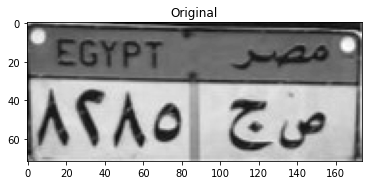

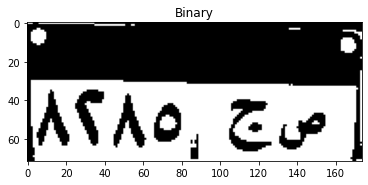

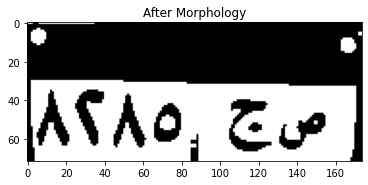

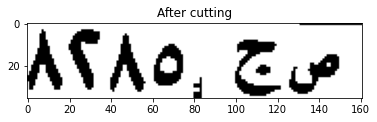

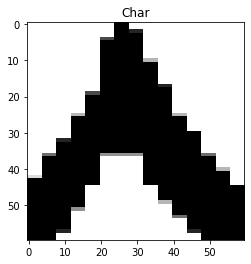

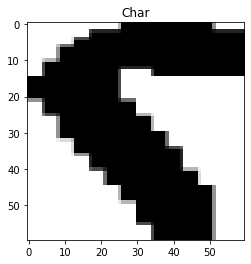

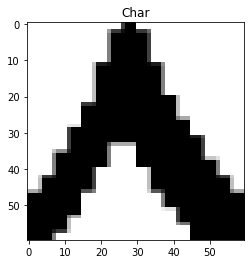

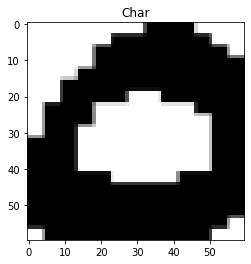

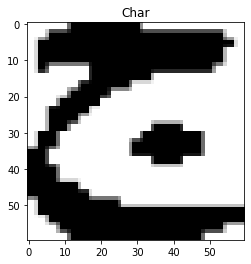

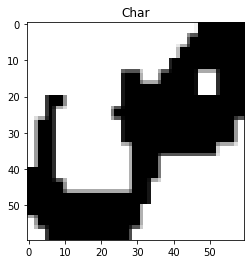

['ص', 'ج', '5', '8', '2', '8']


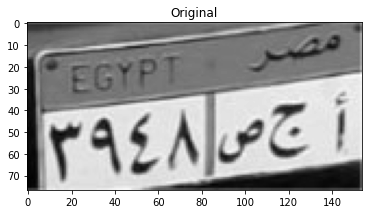

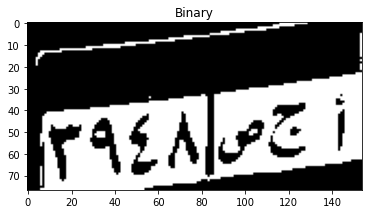

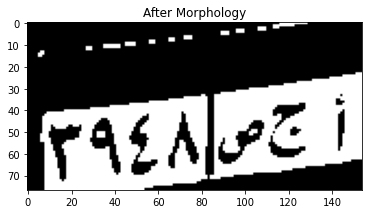

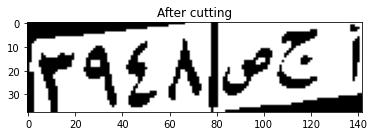

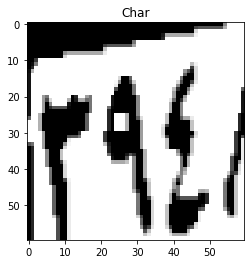

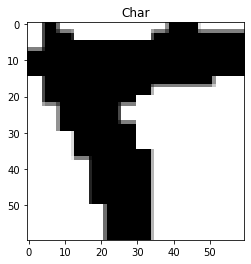

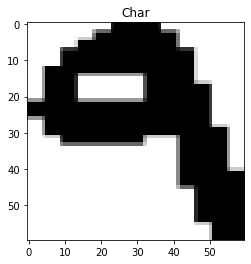

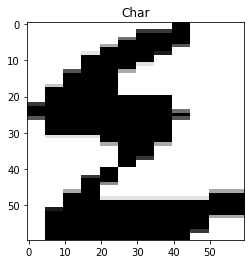

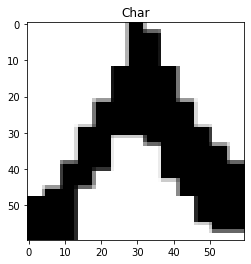

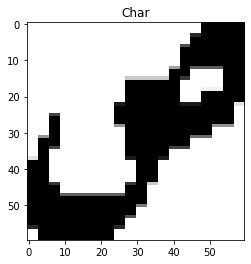

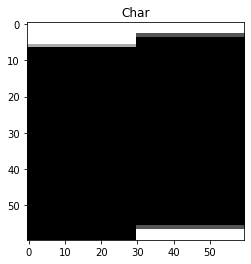

['أ', 'ص', '8', '4', '9', '3', 'ع']


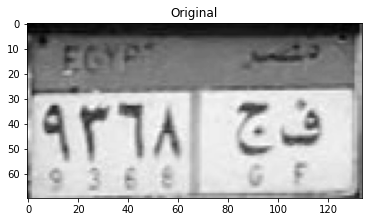

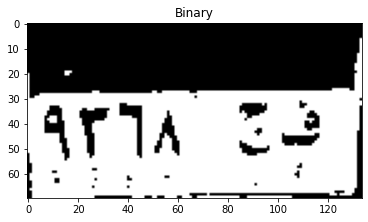

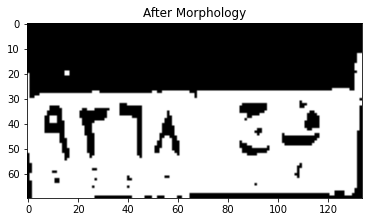

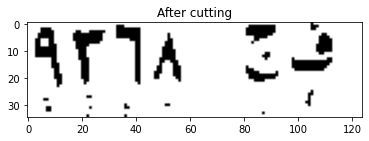

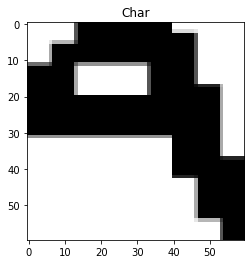

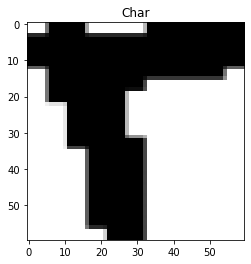

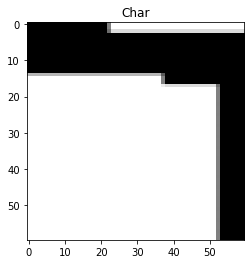

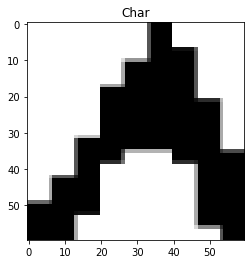

['8', '6', '3', '9']


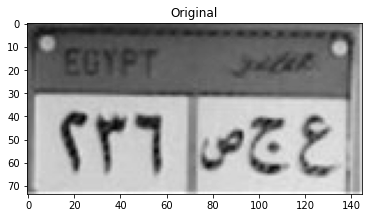

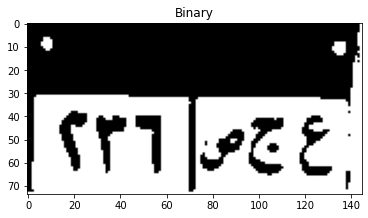

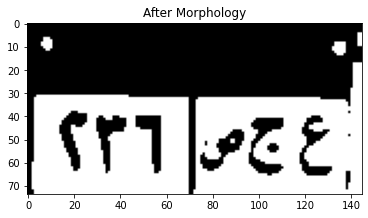

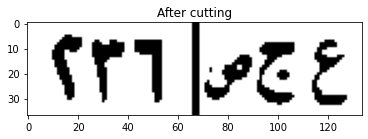

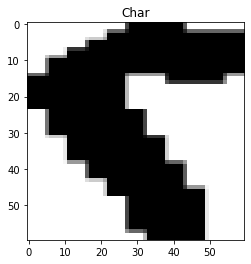

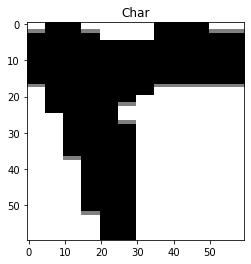

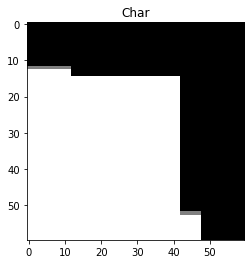

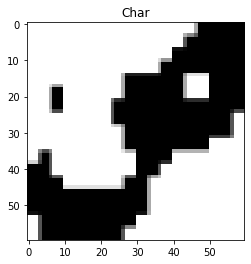

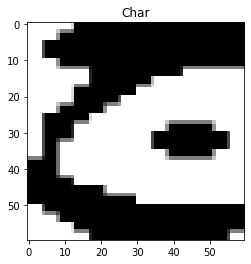

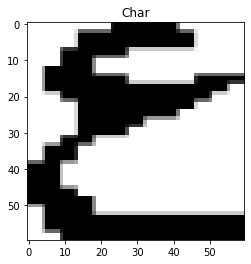

['ع', 'ج', 'ص', '6', '3', '2']


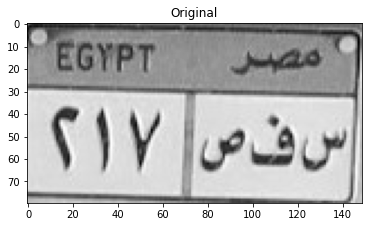

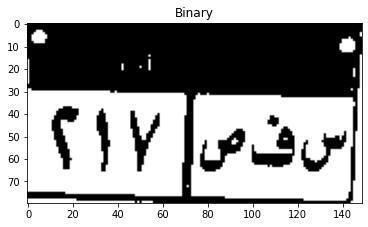

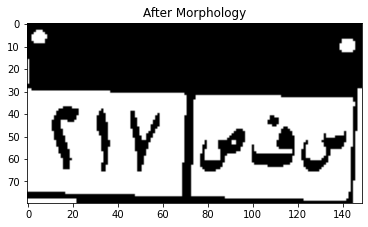

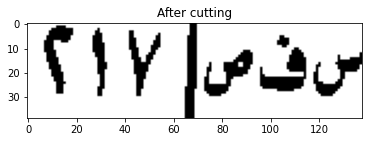

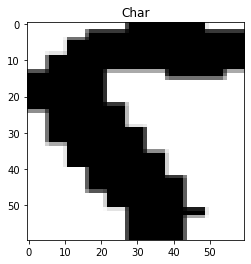

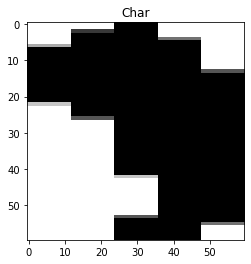

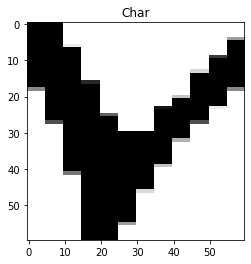

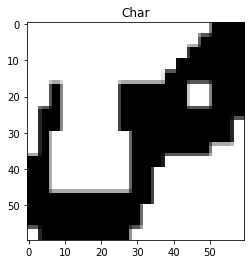

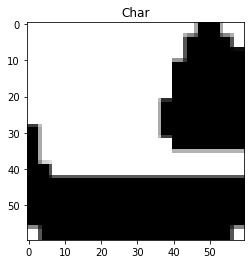

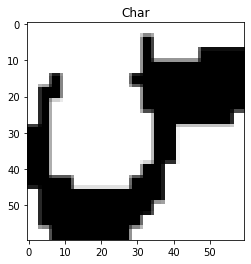

['س', 'ف', 'ص', '7', '1', '2']


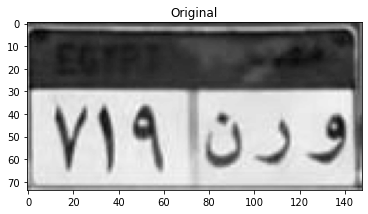

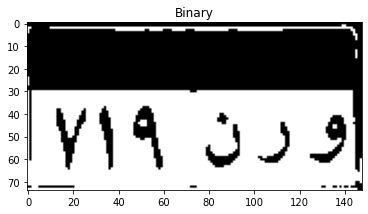

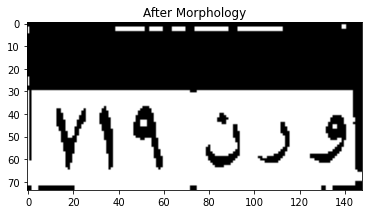

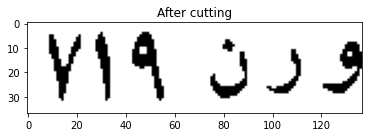

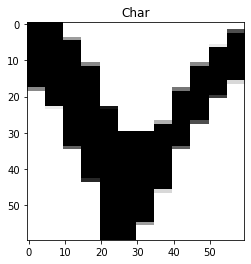

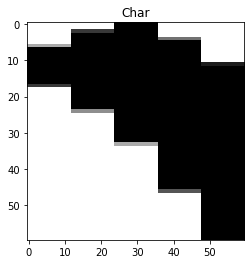

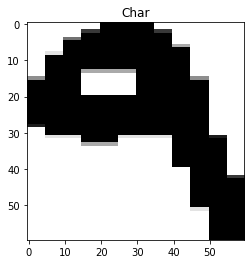

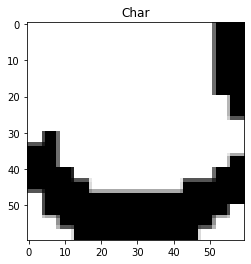

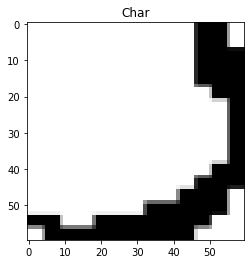

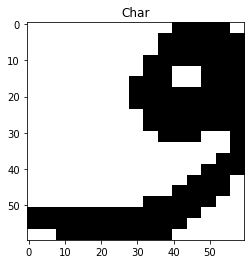

['و', 'ر', 'ن', '9', '1', '7']


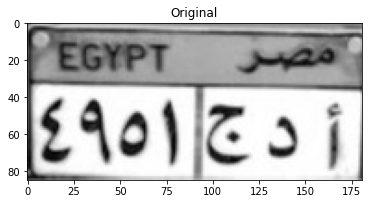

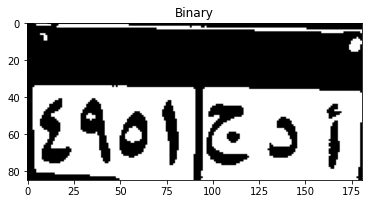

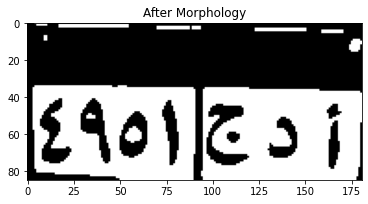

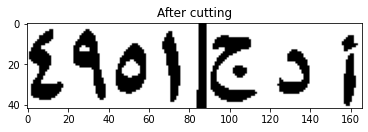

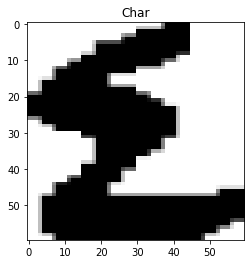

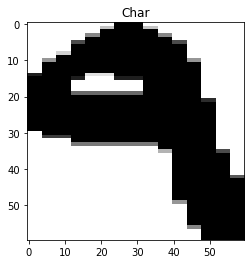

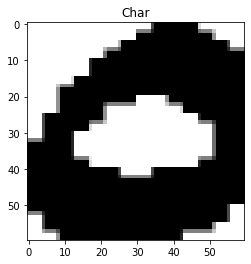

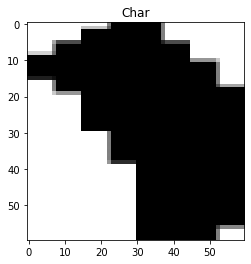

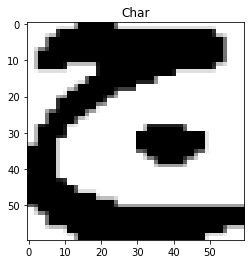

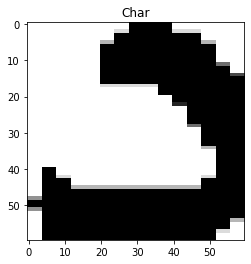

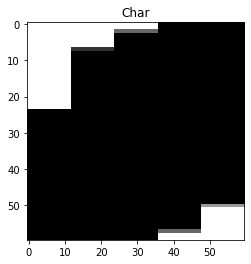

['أ', 'د', 'ج', '1', '5', '9', '4']


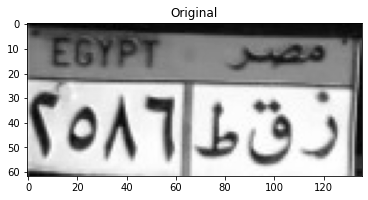

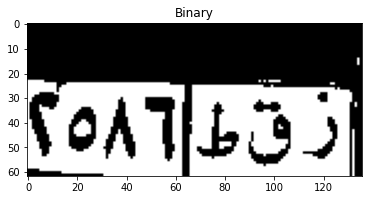

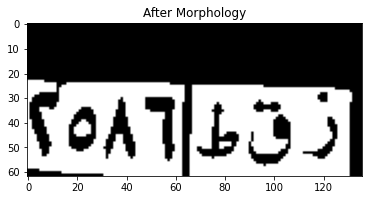

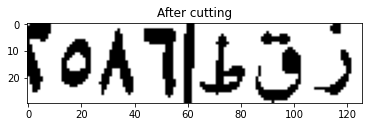

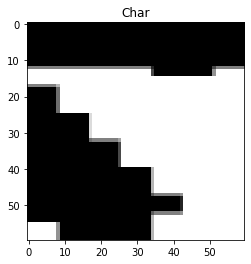

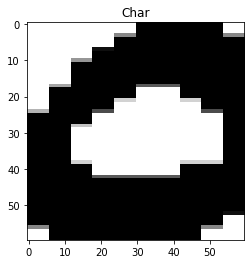

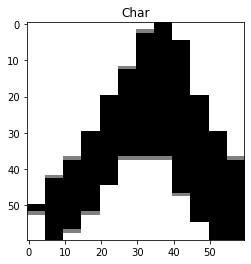

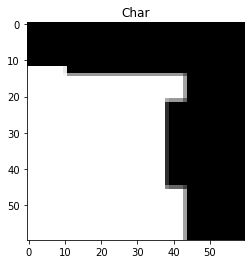

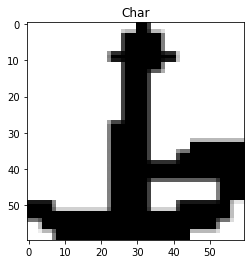

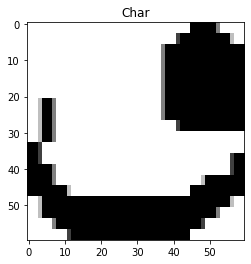

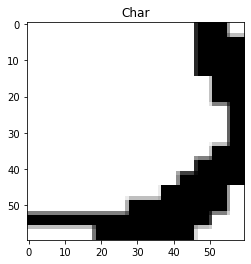

['ز', 'ق', 'ط', '6', '8', '5', '2']


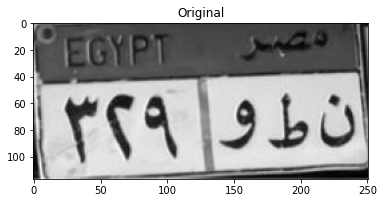

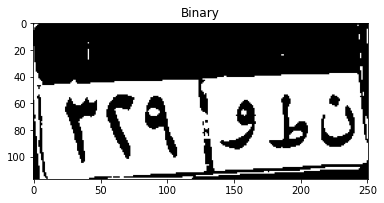

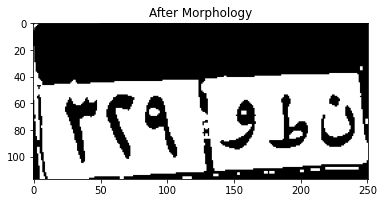

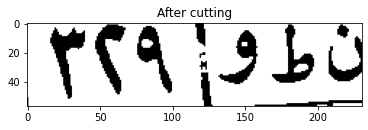

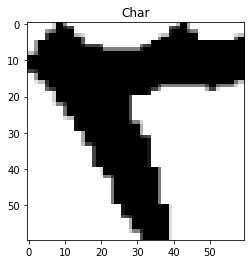

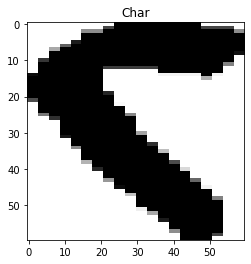

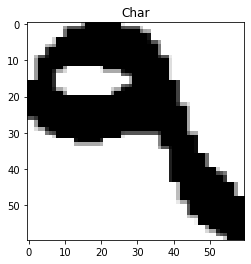

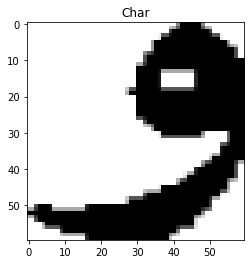

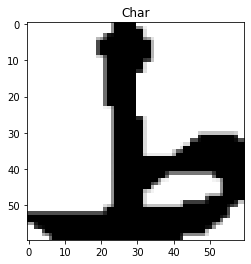

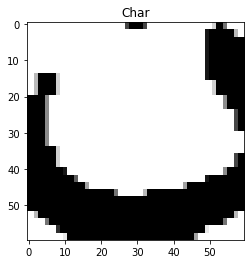

['ن', 'ط', 'و', '9', '2', '3']


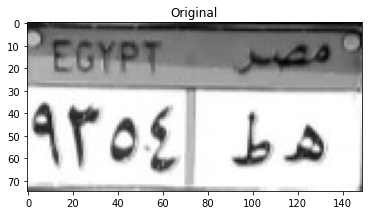

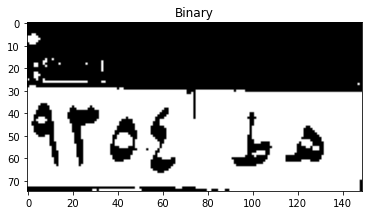

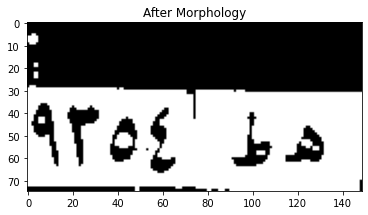

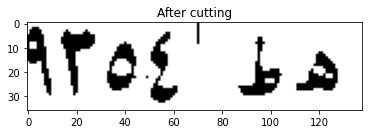

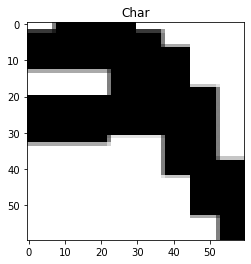

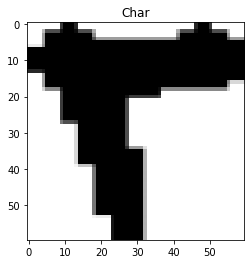

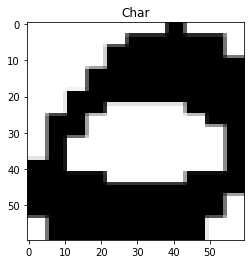

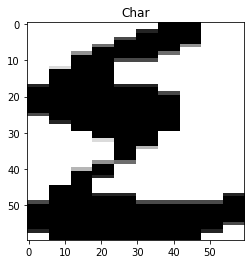

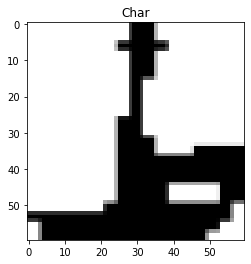

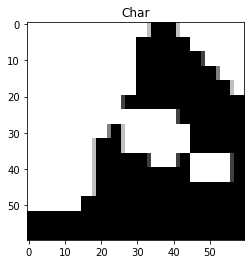

['ه', 'ط', '4', '5', '3', '9']


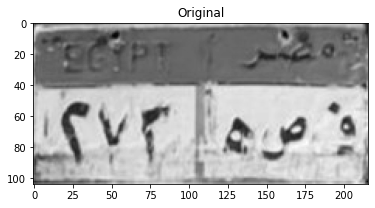

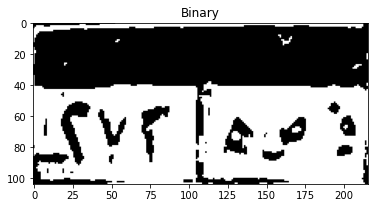

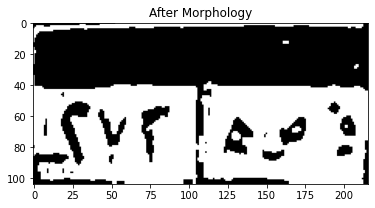

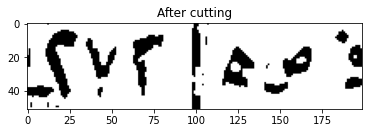

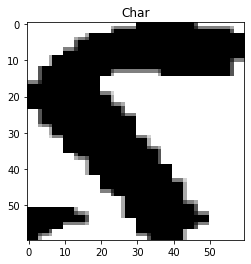

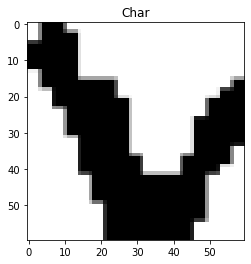

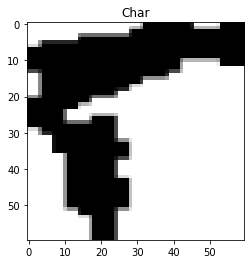

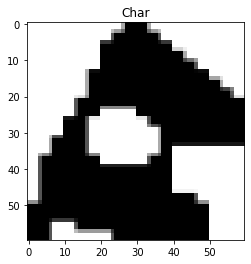

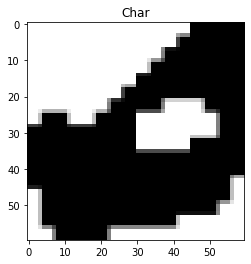

['أ', 'د', '3', '7', '2']


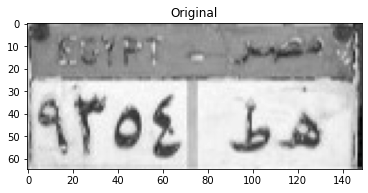

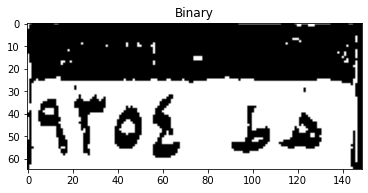

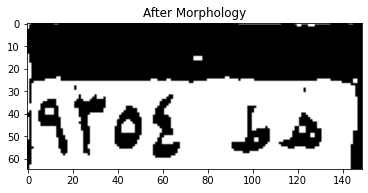

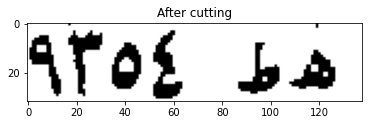

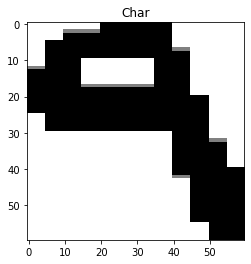

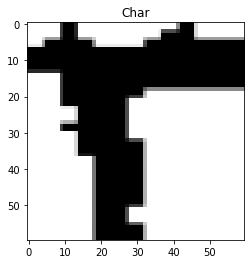

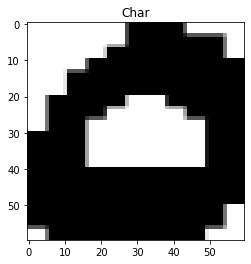

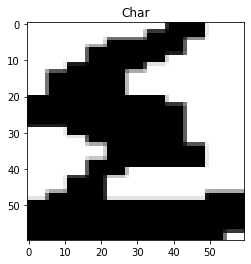

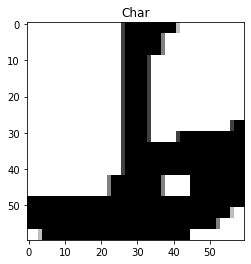

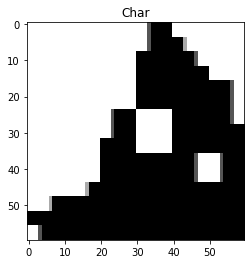

['ه', 'ط', '4', '5', '3', '9']


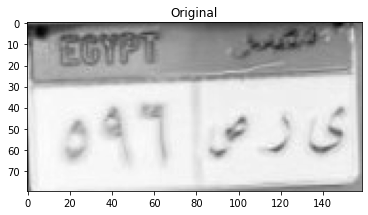

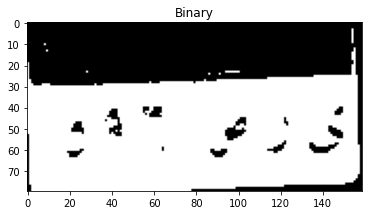

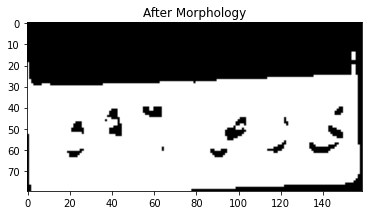

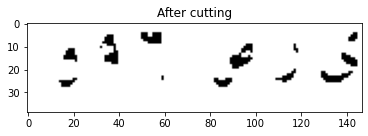

[]


In [153]:
for i in os.listdir('plates_dataset/'):
    image = (rgb2gray(io.imread("plates_dataset/" + i)) * 255).astype("uint8")
    show_images([image], ["Original"])
    image = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    show_images([image], ["Binary"])
    x,y = image.shape
    structuringEl = np.ones((2, 2))        
    image = binary_opening(image, structuringEl)
    show_images([image], ["After Morphology"])
    image = image[int(x//2.2):x-int(x//15),int(y//30):y-int(y//20)]
    show_images([image], ["After cutting"])
    charText = getChars(image)
    print(charText)
